In [1]:
!pip install clarifai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.0/162.0 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.6/177.6 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.3/309.3 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.3/259.3 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 361.7/361.7 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 17.1 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.5
    Uninstalling protobuf-4.25.5:
      Successfully uninstalled protobuf-4.25.5
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.68.1
    Uninstalling grpcio-1.68.1:
      Successfu

In [2]:
from clarifai.client.model import Model
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [3]:
model_url = "https://clarifai.com/clarifai/main/models/apparel-detection"
detector_model = Model(
    url=model_url,
    pat="1fc718434f51433691094fcc989117ea",
)

Enter the full path of the image to test: /content/pant.png
Detected Classes:
- pants: 1.00


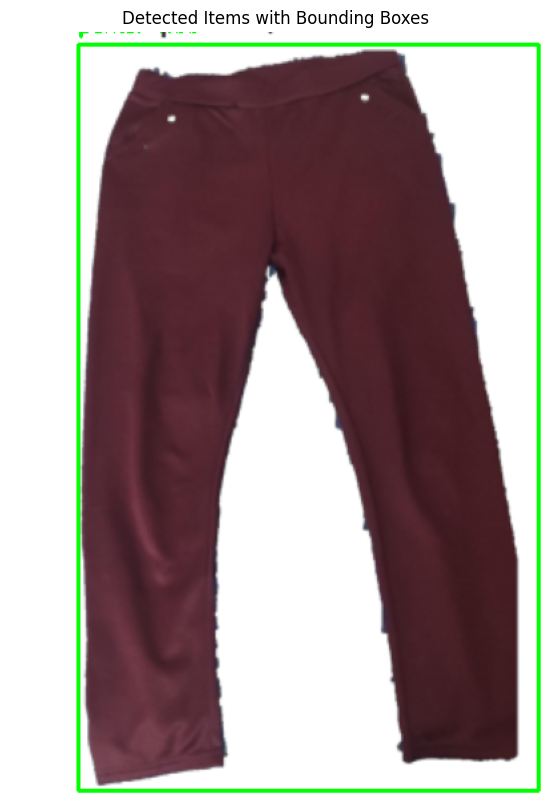

In [5]:
image_path = input("Enter the full path of the image to test: ")
CONFIDENCE_THRESHOLD = 0.6
all_detected_classes = []
if not os.path.exists(image_path):
    print("The specified image does not exist! Please check the path.")
else:
    with open(image_path, "rb") as img_file:
        prediction_response = detector_model.predict_by_bytes(img_file.read(), input_type="image")

    regions = prediction_response.outputs[0].data.regions
    if not regions:
        print("No clothing items detected in the image.")
    else:
        image = cv2.imread(image_path)
        original_image = image.copy()

        for region in regions:
            top_row = region.region_info.bounding_box.top_row
            left_col = region.region_info.bounding_box.left_col
            bottom_row = region.region_info.bounding_box.bottom_row
            right_col = region.region_info.bounding_box.right_col

            height, width, _ = image.shape

            # Bounding box coordinates with bounds checking
            x1 = max(0, min(width, int(left_col * width)))
            y1 = max(0, min(height, int(top_row * height)))
            x2 = max(0, min(width, int(right_col * width)))
            y2 = max(0, min(height, int(bottom_row * height)))

            # Validate the bounding box
            if x1 >= x2 or y1 >= y2:
                print(f"Skipping invalid bounding box: x1={x1}, y1={y1}, x2={x2}, y2={y2}")
                continue

            for concept in region.data.concepts:
                confidence = concept.value
                if confidence >= CONFIDENCE_THRESHOLD:
                    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
                    label = f"{concept.name}: {confidence:.2f}"
                    cv2.putText(
                        image,
                        label,
                        (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        0.5,
                        (0, 255, 0),
                        2,
                    )
                    all_detected_classes.append((concept.name, confidence))
                    break

        if all_detected_classes:
            print("Detected Classes:")
            for class_name, confidence in all_detected_classes:
                print(f"- {class_name}: {confidence:.2f}")
        else:
            print("No classes detected above the confidence threshold.")

        plt.figure(figsize=(10, 10))
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title("Detected Items with Bounding Boxes")
        plt.axis("off")
        plt.show()


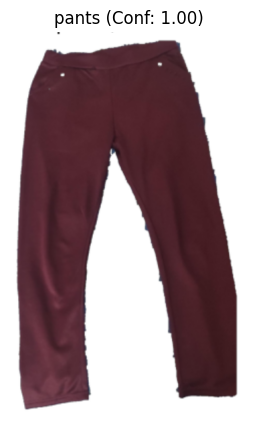

Number of ROIs saved: 1
pants_0: (43, 1, 400, 578) (Confidence: 1.00)


In [6]:
# Constants
PADDING_RATIO = 0.02
PADDING = int(PADDING_RATIO * min(width, height))
ROI_STORAGE = {}  # Dictionary to store filtered ROIs
ALLOWED_CLASSES = {"dress", "top" ,"pants"}  # Classes of interest

# Process all detected regions
for idx, region in enumerate(regions):
    # Bounding box coordinates
    top_row = region.region_info.bounding_box.top_row
    left_col = region.region_info.bounding_box.left_col
    bottom_row = region.region_info.bounding_box.bottom_row
    right_col = region.region_info.bounding_box.right_col

    height, width, _ = original_image.shape

    # Bounding box coordinates with bounds checking
    x1 = max(0, min(width, int(left_col * width))) - PADDING
    y1 = max(0, min(height, int(top_row * height))) - PADDING
    x2 = max(0, min(width, int(right_col * width))) + PADDING
    y2 = max(0, min(height, int(bottom_row * height))) + PADDING

    # Ensure bounding box is valid
    x1 = max(0, x1)
    y1 = max(0, y1)
    x2 = min(width, x2)
    y2 = min(height, y2)

    # Crop the region of interest (ROI)
    roi = original_image[y1:y2, x1:x2]

    # Identify clothing type and confidence
    for concept in region.data.concepts:
        if concept.value >= CONFIDENCE_THRESHOLD and concept.name in ALLOWED_CLASSES:
            clothing_type = concept.name
            confidence = concept.value

            # Save the ROI in the storage
            roi_key = f"{clothing_type}_{idx}"  # Create a unique key for each ROI
            ROI_STORAGE[roi_key] = {
                "image": roi,
                "coordinates": (x1, y1, x2, y2),
                "confidence": confidence,
            }

            # Display cropped ROI (optional)
            plt.figure(figsize=(5, 5))
            plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
            plt.title(f"{clothing_type} (Conf: {confidence:.2f})")
            plt.axis("off")
            plt.show()

            # Save ROI to file (optional)
            output_path = f"{clothing_type}_{idx}.jpg"
            cv2.imwrite(output_path, roi)

            break  # Only process the first valid concept per region

# Verify the stored ROIs
print(f"Number of ROIs saved: {len(ROI_STORAGE)}")
for key, value in ROI_STORAGE.items():
    print(f"{key}: {value['coordinates']} (Confidence: {value['confidence']:.2f})")


In [7]:
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

--2024-12-13 04:53:08--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.164.78.121, 18.164.78.72, 18.164.78.81, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.164.78.121|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G  68.1MB/s    in 29s     

2024-12-13 04:53:37 (83.3 MB/s) - ‘sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]



In [8]:
!pip install git+https://github.com/facebookresearch/segment-anything.git

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-xqpuv_mv
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-xqpuv_mv
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36592 sha256=85994827a6d079fe4eb738766ea90f26f278d2643bc1b0e4f02aa8bc3b0e6eca
  Stored in directory: /tmp/pip-ephem-wheel-cache-eirnwic8/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment_anything


In [9]:
import torch
from segment_anything import SamPredictor, sam_model_registry
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [11]:
# Constants
SAM_MODEL_TYPE = "vit_h"  # Choose from 'vit_h', 'vit_l', 'vit_b'
SAM_CHECKPOINT_PATH = "/content/sam_vit_h_4b8939.pth"

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cpu'

In [13]:
print("Loading SAM model...")
sam = sam_model_registry[SAM_MODEL_TYPE](checkpoint=SAM_CHECKPOINT_PATH)
sam.to(device="cpu")
predictor = SamPredictor(sam)
print("SAM model loaded successfully.")

Loading SAM model...
SAM model loaded successfully.


Isolated item saved to: dress_only_pants.png


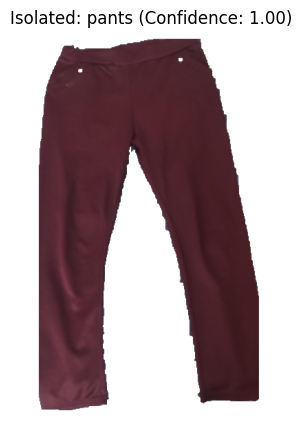

Skipping region with low confidence: 0.33


In [10]:
# Extraction and processing of detected regions
for region in regions:
    # Check if the class is "dress", "top", "pants", "outerwear", or "skirt"
    class_name = region.data.concepts[0].name.lower()  # Assuming the first concept is the most relevant
    if class_name not in {"dress", "top", "outerwear", "pants"}:
        print(f"Skipping region classified as: {class_name}")
        continue

    # Get confidence value
    confidence = region.data.concepts[0].value
    if confidence < CONFIDENCE_THRESHOLD:
        print(f"Skipping region with low confidence: {confidence:.2f}")
        continue

    # Extract bounding box coordinates
    top_row = region.region_info.bounding_box.top_row
    left_col = region.region_info.bounding_box.left_col
    bottom_row = region.region_info.bounding_box.bottom_row
    right_col = region.region_info.bounding_box.right_col

    # Image dimensions
    height, width, _ = original_image.shape

    # Calculate bounding box pixel coordinates
    x1 = max(0, min(width, int(left_col * width)))
    y1 = max(0, min(height, int(top_row * height)))
    x2 = max(0, min(width, int(right_col * width)))
    y2 = max(0, min(height, int(bottom_row * height)))

    # Validate the bounding box
    if x1 >= x2 or y1 >= y2:
        print(f"Skipping invalid bounding box: x1={x1}, y1={y1}, x2={x2}, y2={y2}")
        continue

    # Crop the detected region
    detected_region = original_image[y1:y2, x1:x2]

    # Initialize GrabCut mask and models
    mask = np.zeros(detected_region.shape[:2], dtype=np.uint8)
    bg_model = np.zeros((1, 65), np.float64)
    fg_model = np.zeros((1, 65), np.float64)

    # Define GrabCut rectangle
    grabcut_rect = (10, 10, detected_region.shape[1] - 20, detected_region.shape[0] - 20)

    # Apply GrabCut
    cv2.grabCut(
        detected_region,
        mask,
        grabcut_rect,
        bg_model,
        fg_model,
        iterCount=10,
        mode=cv2.GC_INIT_WITH_RECT,
    )

    # Refine GrabCut mask
    grabCut_mask = np.where((mask == 2) | (mask == 0), 0, 1).astype("uint8")

    # Isolate the detected item
    dress_only = detected_region * grabCut_mask[:, :, np.newaxis]

    # Add alpha channel for transparency
    dress_with_alpha = cv2.cvtColor(dress_only, cv2.COLOR_BGR2BGRA)
    dress_with_alpha[:, :, 3] = grabCut_mask * 255

    # Save the isolated item
    output_path = f"dress_only_{class_name}.png"
    cv2.imwrite(output_path, dress_with_alpha)
    print(f"Isolated item saved to: {output_path}")

    # Display the isolated item
    plt.figure(figsize=(5, 5))
    plt.imshow(cv2.cvtColor(dress_with_alpha, cv2.COLOR_BGRA2RGBA))
    plt.title(f"Isolated: {class_name} (Confidence: {confidence:.2f})")
    plt.axis("off")
    plt.show()



In [ ]:
# Function to run SAM on an ROI
def run_sam_on_roi(roi, roi_key):
    """
    Run SAM on a single ROI and return the segmentation mask.
    :param roi: Cropped ROI image as a numpy array
    :param roi_key: Unique key for the ROI (e.g., 'dress_0')
    :return: Segmentation mask as a numpy array
    """
    # Preprocess ROI for SAM
    input_image = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    predictor.set_image(input_image)

    # Provide a point for SAM (center of the ROI)
    height, width, _ = input_image.shape
    input_point = np.array([[width // 2, height // 2]])
    input_label = np.array([1])  # Positive point

    # Run SAM's prediction
    masks, scores, logits = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=False  # Set to True if you want multiple masks
    )

    # Return the first mask (single mask for now)
    Sam_mask = masks[0]  # Mask is a binary numpy array

    # Visualize mask on the image
    segmented_image = input_image.copy()
    segmented_image[Sam_mask] = [0, 255, 0]  # Highlight the mask in green

    # Save or display the segmented image
    plt.figure(figsize=(5, 5))
    plt.imshow(segmented_image)
    plt.title(f"Segmented ROI: {roi_key}")
    plt.axis("off")
    plt.show()

    return Sam_mask

Processing dress_2...


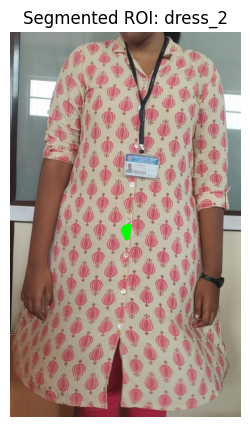

SAM processing complete.
Number of segmented ROIs: 1


In [ ]:
# Process all ROIs in ROI_STORAGE
segmentation_results = {}  # Store segmentation masks for each ROI
for roi_key, roi_data in ROI_STORAGE.items():
    roi_image = roi_data["image"]
    print(f"Processing {roi_key}...")

    # Run SAM on the ROI
    segmentation_mask = run_sam_on_roi(roi_image, roi_key)

    # Store the result
    segmentation_results[roi_key] = {
        "mask": segmentation_mask,
        "coordinates": roi_data["coordinates"],
        "confidence": roi_data["confidence"],
    }

print("SAM processing complete.")
print(f"Number of segmented ROIs: {len(segmentation_results)}")

In [ ]:
# Function to run GrabCut on an ROI
def run_grabcut_on_roi(roi):
    mask = np.zeros(roi.shape[:2], dtype=np.uint8)
    bg_model = np.zeros((1, 65), np.float64)
    fg_model = np.zeros((1, 65), np.float64)
    grabcut_rect = (10, 10, roi.shape[1] - 20, roi.shape[0] - 20)

    cv2.grabCut(roi, mask, grabcut_rect, bg_model, fg_model, iterCount=10, mode=cv2.GC_INIT_WITH_RECT)
    refined_mask = np.where((mask == 2) | (mask == 0), 0, 1).astype("uint8")  # Refine mask
    return refined_mask

In [ ]:
# Function to ensemble SAM and GrabCut masks
def ensemble_sam_grabcut(sam_mask, grabcut_mask, alpha=0.5):
    sam_mask = np.array(sam_mask, dtype=np.float32)
    grabcut_mask = np.array(grabcut_mask, dtype=np.float32)

    # Weighted average of the two masks
    combined_mask = alpha * sam_mask + (1 - alpha) * grabcut_mask

    # Refine combined mask (e.g., by thresholding)
    combined_mask = refine_mask(combined_mask, threshold=0.5)

    return combined_mask

In [ ]:
# Function to refine the mask (thresholding or smoothing)
def refine_mask(mask, threshold=0.5):
    return np.where(mask >= threshold, 1, 0).astype(np.uint8)

In [ ]:
# Function to visualize the mask
def visualize_mask(mask, original_image, title="Mask"):
    masked_image = original_image.copy()
    masked_image[mask == 1] = [0, 255, 0]  # Highlight the masked area in green

    plt.figure(figsize=(5, 5))
    plt.imshow(masked_image)
    plt.title(title)
    plt.axis("off")
    plt.show()

In [ ]:
# Function to run SAM on an ROI
def run_sam_on_roi(roi, roi_key):
    input_image = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    predictor.set_image(input_image)
    height, width, _ = input_image.shape
    input_point = np.array([[width // 2, height // 2]])  # Center of the ROI
    input_label = np.array([1])  # Positive point for SAM

    masks, scores, logits = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=False
    )

    sam_mask = masks[0]  # Take the first mask (binary)
    return sam_mask

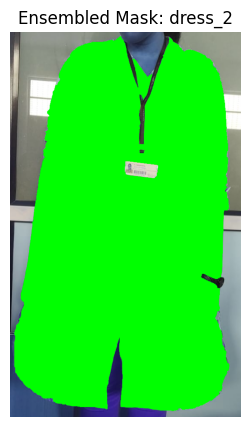

In [ ]:
# Process and ensemble all ROIs
def process_and_ensemble_all_rois():
    for roi_key, roi_data in ROI_STORAGE.items():
        roi_image = roi_data["image"]
        roi_coordinates = roi_data["coordinates"]
        confidence = roi_data["confidence"]

        # Run SAM inference on the ROI
        sam_mask = run_sam_on_roi(roi_image, roi_key)

        # Run GrabCut on the ROI
        grabcut_mask = run_grabcut_on_roi(roi_image)

        # Ensemble SAM and GrabCut masks
        combined_mask = ensemble_sam_grabcut(sam_mask, grabcut_mask, alpha=0.5)

        # Visualize the combined result
        visualize_mask(combined_mask, roi_image, title=f"Ensembled Mask: {roi_key}")

        # Optionally save the final ensemble mask to a file
        output_path = f"ensemble_{roi_key}.jpg"
        cv2.imwrite(output_path, combined_mask * 255)  # Convert mask to 0-255 range for saving

# Call the function to process and ensemble all ROIs
process_and_ensemble_all_rois()


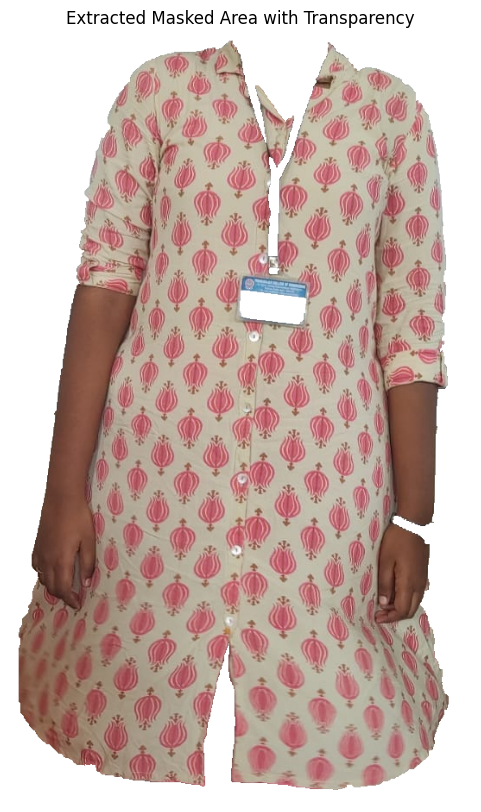

In [ ]:
def extract_and_display_transparent_mask(original_image, ensembled_mask):
    """
    Extract the masked region and make the rest of the image transparent.

    Parameters:
    - original_image: The original image (numpy array, typically BGR format).
    - ensembled_mask: The binary mask (numpy array).

    Returns:
    - None (displays the result directly).
    """
    # Ensure the mask is binary (0 and 1 only)
    binary_mask = (ensembled_mask > 0).astype(np.uint8)

    # Convert the original image to RGBA (adding an alpha channel)
    rgba_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2BGRA)

    # Set the alpha channel to match the mask
    rgba_image[:, :, 3] = binary_mask * 255

    # Display the transparent result
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(rgba_image, cv2.COLOR_BGRA2RGBA))
    plt.title("Extracted Masked Area with Transparency")
    plt.axis("off")
    plt.show()

    return rgba_image


# Process and extract transparent masked areas for all ROIs
def process_and_extract_transparent_masked_areas():
    for roi_key, roi_data in ROI_STORAGE.items():
        roi_image = roi_data["image"]
        roi_coordinates = roi_data["coordinates"]
        confidence = roi_data["confidence"]

        # Run SAM inference on the ROI
        sam_mask = run_sam_on_roi(roi_image, roi_key)

        # Run GrabCut on the ROI
        grabcut_mask = run_grabcut_on_roi(roi_image)

        # Ensemble SAM and GrabCut masks
        combined_mask = ensemble_sam_grabcut(sam_mask, grabcut_mask, alpha=0.5)

        # Extract and display the transparent masked area
        transparent_image = extract_and_display_transparent_mask(roi_image, combined_mask)

        # Optionally save the transparent image
        output_path = f"transparent_{roi_key}.png"
        cv2.imwrite(output_path, transparent_image)


# Call the function to process and extract transparent masked areas
process_and_extract_transparent_masked_areas()


In [ ]:
def remove_skin_from_mask(masked_image, mask):
    """
    Remove skin regions from the mask of extracted clothing.

    Parameters:
    - masked_image: The image with the mask applied.
    - mask: Binary mask of the extracted clothing.

    Returns:
    - refined_mask: Mask with skin regions removed.
    """
    # Convert the masked image to HSV color space
    hsv_image = cv2.cvtColor(masked_image, cv2.COLOR_BGR2HSV)

    # Define HSV range for skin color
    lower_skin = np.array([0, 20, 70], dtype=np.uint8)  # Adjust as needed
    upper_skin = np.array([20, 255, 255], dtype=np.uint8)  # Adjust as needed

    # Create a binary mask for skin regions
    skin_mask = cv2.inRange(hsv_image, lower_skin, upper_skin)

    # Invert the skin mask
    skin_mask_inverted = cv2.bitwise_not(skin_mask)

    # Combine the inverted skin mask with the original mask
    refined_mask = cv2.bitwise_and(mask, mask, mask=skin_mask_inverted)

    return refined_mask


def extract_and_display_transparent_mask(original_image, ensembled_mask):
    """
    Extract the masked region, remove skin, and make the rest of the image transparent.

    Parameters:
    - original_image: The original image (numpy array, typically BGR format).
    - ensembled_mask: The binary mask (numpy array).

    Returns:
    - rgba_image: The resulting transparent image.
    """
    # Ensure the mask is binary (0 and 1 only)
    binary_mask = (ensembled_mask > 0).astype(np.uint8)

    # Remove skin regions from the mask
    refined_mask = remove_skin_from_mask(original_image, binary_mask)

    # Convert the original image to RGBA (adding an alpha channel)
    rgba_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2BGRA)

    # Set the alpha channel to match the refined mask
    rgba_image[:, :, 3] = refined_mask * 255

    # Display the transparent result
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(rgba_image, cv2.COLOR_BGRA2RGBA))
    plt.title("Extracted Masked Area with Transparency (Skin Removed)")
    plt.axis("off")
    plt.show()

    return rgba_image


# Process and extract transparent masked areas for all ROIs
def process_and_extract_transparent_masked_areas():
    for roi_key, roi_data in ROI_STORAGE.items():
        roi_image = roi_data["image"]
        roi_coordinates = roi_data["coordinates"]
        confidence = roi_data["confidence"]

        # Run SAM inference on the ROI
        sam_mask = run_sam_on_roi(roi_image, roi_key)

        # Run GrabCut on the ROI
        grabcut_mask = run_grabcut_on_roi(roi_image)

        # Ensemble SAM and GrabCut masks
        combined_mask = ensemble_sam_grabcut(sam_mask, grabcut_mask, alpha=0.5)

        # Extract and display the transparent masked area
        transparent_image = extract_and_display_transparent_mask(roi_image, combined_mask)

        # Optionally save the transparent image
        output_path = f"transparent_{roi_key}.png"
        cv2.imwrite(output_path, transparent_image)


# Call the function to process and extract transparent masked areas
process_and_extract_transparent_masked_areas()
